In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
sys.path.append("../src")

In [3]:
from utils import read_xray
from glob import glob
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

### Understanding Reading DICOM files

In [4]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [ ]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data


In [8]:
#Monochrome1
dicom_1 = pydicom.read_file("/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/train/000434271f63a053c4128a0ba6352c7f.dicom")
#Monochrome2
dicom_2 = pydicom.read_file("/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/train/001d127bad87592efe45a5c7678f8b8d.dicom")


In [9]:
dicom_1

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 000434271f63a053c4128a0ba6352c7f
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: ''
(0002, 0016) Source Application Entity Title     AE: 'VITREA1'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'O'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME1'
(0028, 0010) Rows                                US: 2836
(0028, 0011) Columns                             US: 2336
(0028, 0030) Pixel Spacing            

In [10]:
dicom_2

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 154
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 001d127bad87592efe45a5c7678f8b8d
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's Age                       AS: '058Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0008) Number of Frames                    IS: '1'
(0028, 0010) Rows                                US: 3072
(0028, 0011) Columns                   

In [11]:
dicom_1.pixel_array

array([[2871, 2858, 2833, ..., 3973, 3977, 3988],
       [3064, 3033, 3022, ..., 3999, 4003, 4002],
       [3241, 3207, 3193, ..., 4014, 4013, 4016],
       ...,
       [4087, 4089, 4083, ..., 4089, 4095, 4093],
       [4087, 4089, 4082, ..., 4088, 4095, 4093],
       [4087, 4090, 4083, ..., 4089, 4095, 4093]], dtype=uint16)

In [13]:
dicom_2.pixel_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 3, ..., 3, 0, 0],
       ...,
       [0, 0, 3, ..., 3, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

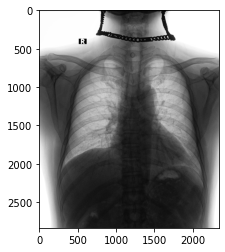

In [15]:
plt.imshow(dicom_1.pixel_array, cmap = 'gray')

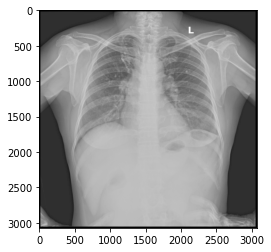

In [16]:
plt.imshow(dicom_2.pixel_array, cmap = 'gray')

In [17]:
#VOI is value of interst and lut is lock up table
data_1 = apply_voi_lut(dicom_1.pixel_array, dicom_1)
data_2 = apply_voi_lut(dicom_2.pixel_array, dicom_2)

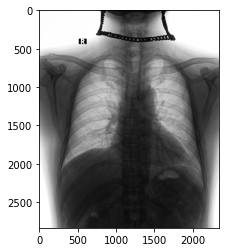

In [20]:
plt.imshow(data_1, cmap = 'gray')

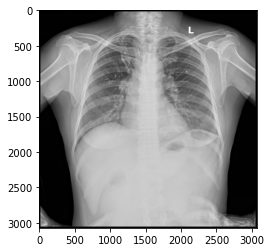

In [21]:
plt.imshow(data_2, cmap = 'gray')

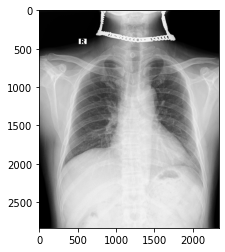

In [23]:
#fixing MONOChrome
plt.imshow(np.amax(data_1) - data_1, cmap = 'gray')

In [24]:
np.amax(data_1)

4095.0

In [26]:
np.min(data_1)

0.0

### Annotations Path

In [5]:
train_local_annotations_path = "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_train.csv"
train_global_annotations_path = "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_train.csv"

test_local_annotations_path = "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_test.csv"
test_global_annotations_path = "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_test.csv"

In [6]:
train_local_annotations = pd.read_csv(train_local_annotations_path)
train_global_annotations = pd.read_csv(train_global_annotations_path)
test_local_annotations = pd.read_csv(test_local_annotations_path)
test_global_annotations = pd.read_csv(test_global_annotations_path)

In [7]:
print(train_global_annotations.shape)
train_global_annotations.head(10)

(45000, 30)


,image_id,rad_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Clavicle fracture,Consolidation,Edema,Emphysema,...,Pneumothorax,Pulmonary fibrosis,Rib fracture,Other lesion,COPD,Lung tumor,Pneumonia,Tuberculosis,Other diseases,No finding
0,000434271f63a053c4128a0ba6352c7f,R2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,000434271f63a053c4128a0ba6352c7f,R3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,000434271f63a053c4128a0ba6352c7f,R6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,00053190460d56c53cc3e57321387478,R11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,00053190460d56c53cc3e57321387478,R2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,00053190460d56c53cc3e57321387478,R7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0005e8e3701dfb1dd93d53e2ff537b6e,R10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
7,0005e8e3701dfb1dd93d53e2ff537b6e,R8,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
8,0005e8e3701dfb1dd93d53e2ff537b6e,R9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
9,0006e0a85696f6bb578e84fafa9a5607,R11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
print(train_local_annotations.shape)
train_local_annotations.head(10)

(69052, 7)


,image_id,rad_id,class_name,x_min,y_min,x_max,y_max
0,000434271f63a053c4128a0ba6352c7f,R2,No finding,NaN,NaN,NaN,NaN
1,000434271f63a053c4128a0ba6352c7f,R3,No finding,NaN,NaN,NaN,NaN
2,000434271f63a053c4128a0ba6352c7f,R6,No finding,NaN,NaN,NaN,NaN
3,00053190460d56c53cc3e57321387478,R11,No finding,NaN,NaN,NaN,NaN
4,00053190460d56c53cc3e57321387478,R2,No finding,NaN,NaN,NaN,NaN
5,00053190460d56c53cc3e57321387478,R7,No finding,NaN,NaN,NaN,NaN
6,0005e8e3701dfb1dd93d53e2ff537b6e,R10,Infiltration,900.956970,587.809021,1205.359985,888.710999
7,0005e8e3701dfb1dd93d53e2ff537b6e,R10,Lung Opacity,900.956970,587.809021,1205.359985,888.710999
8,0005e8e3701dfb1dd93d53e2ff537b6e,R8,Consolidation,932.471985,567.778992,1197.770020,896.408997
9,0005e8e3701dfb1dd93d53e2ff537b6e,R8,Nodule/Mass,932.471985,567.778992,1197.770020,896.408997


In [9]:
print(test_local_annotations.shape)
test_local_annotations.head(10)

(4748, 6)


,image_id,class_name,x_min,y_min,x_max,y_max
0,e0dc2e79105ad93532484e956ef8a71a,Calcification,1221.560976,661.580417,1343.298780,783.318222
1,e0dc2e79105ad93532484e956ef8a71a,Cardiomegaly,638.695122,1310.848710,1800.737805,1937.982856
2,e0dc2e79105ad93532484e956ef8a71a,ILD,1693.756098,1392.007246,1929.853659,1941.671881
3,e0dc2e79105ad93532484e956ef8a71a,Pneumothorax,399.924053,145.803282,1016.600328,510.138208
4,e0dc2e79105ad93532484e956ef8a71a,Pneumothorax,334.300846,493.762382,453.145487,744.509170
5,e0dc2e79105ad93532484e956ef8a71a,Pleural effusion,229.975703,1482.203045,644.450374,1945.701602
6,e0dc2e79105ad93532484e956ef8a71a,Atelectasis,379.275719,1248.225409,504.063792,1500.029913
7,e0dc2e79105ad93532484e956ef8a71a,Pneumothorax,283.456305,1381.926915,414.929454,1546.825440
8,0aed23e64ebdea798486056b4f174424,Pleural effusion,1593.050179,1885.493865,2164.350008,2288.954196
9,0aed23e64ebdea798486056b4f174424,Pleural effusion,162.061085,1757.177093,881.412855,2229.059285


In [10]:
print(test_global_annotations.shape)
test_global_annotations.head(10)

(3000, 29)


,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Clavicle fracture,Consolidation,Edema,Emphysema,Enlarged PA,...,Pneumothorax,Pulmonary fibrosis,Rib fracture,Other lesion,COPD,Lung tumor,Pneumonia,Tuberculosis,Other diseases,No finding
0,e0dc2e79105ad93532484e956ef8a71a,0,1,1,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
1,0aed23e64ebdea798486056b4f174424,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,aa15cfcfca7605465ca0513902738b95,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,665c4a6d2693dc0286d65ab479c9b169,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,42da2c134b53cb5594774d3d29faac59,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,c7179539654a1b3b7977e56e7e3009d5,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,bfd1974dc9778aadb407a11b57ab748f,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,618777b8305b062583337d9a6b7a3d4e,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
8,e54b5a593bc03c789ecdc18d8270964e,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,3019aec706bd013e1e3348564fbfd086,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


### Checking Data leakage

In [33]:
print(len(np.unique(train_global_annotations['image_id'])))
print(len(np.unique(test_global_annotations['image_id'])))
print(len(np.unique(np.concatenate((train_global_annotations['image_id'],test_global_annotations['image_id'])))))

15000
3000
18000


In [34]:
print(len(np.unique(train_local_annotations['image_id'])))
print(len(np.unique(test_local_annotations['image_id'])))
print(len(np.unique(np.concatenate((train_local_annotations['image_id'],test_local_annotations['image_id'])))))

15000
3000
18000


### Global annotations

In [13]:
print(np.unique(train_global_annotations['rad_id']))

['R1' 'R10' 'R11' 'R12' 'R13' 'R14' 'R15' 'R16' 'R17' 'R2' 'R3' 'R4' 'R5'
 'R6' 'R7' 'R8' 'R9']


In [14]:
col = train_global_annotations.columns.values
print(col)

['image_id' 'rad_id' 'Aortic enlargement' 'Atelectasis' 'Calcification'
 'Cardiomegaly' 'Clavicle fracture' 'Consolidation' 'Edema' 'Emphysema'
 'Enlarged PA' 'ILD' 'Infiltration' 'Lung Opacity' 'Lung cavity'
 'Lung cyst' 'Mediastinal shift' 'Nodule/Mass' 'Pleural effusion'
 'Pleural thickening' 'Pneumothorax' 'Pulmonary fibrosis' 'Rib fracture'
 'Other lesion' 'COPD' 'Lung tumor' 'Pneumonia' 'Tuberculosis'
 'Other diseases' 'No finding']


In [15]:
all_labels = np.delete(col, [0,1])
print(all_labels)
print(len(all_labels))

['Aortic enlargement' 'Atelectasis' 'Calcification' 'Cardiomegaly'
 'Clavicle fracture' 'Consolidation' 'Edema' 'Emphysema' 'Enlarged PA'
 'ILD' 'Infiltration' 'Lung Opacity' 'Lung cavity' 'Lung cyst'
 'Mediastinal shift' 'Nodule/Mass' 'Pleural effusion' 'Pleural thickening'
 'Pneumothorax' 'Pulmonary fibrosis' 'Rib fracture' 'Other lesion' 'COPD'
 'Lung tumor' 'Pneumonia' 'Tuberculosis' 'Other diseases' 'No finding']
28


In [121]:
count = []
for i in all_labels: 
    s = (15000- (np.sum(train_global_annotations.groupby(['image_id']).sum()[i] == 0)))
    count.append(s)
    
Count = {}
for i,j in enumerate(all_labels):
    Count[j] = count[i] 


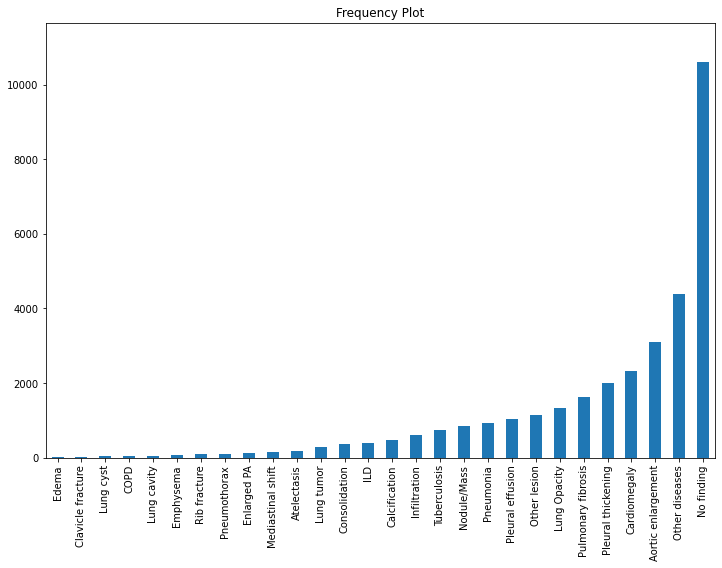

In [187]:
df = pd.DataFrame(count, index = all_labels)
df = df.sort_values(by=[0])
ax = df.plot(kind = 'bar', figsize=(12, 8), title = 'Frequency Plot', legend = False)
# ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)

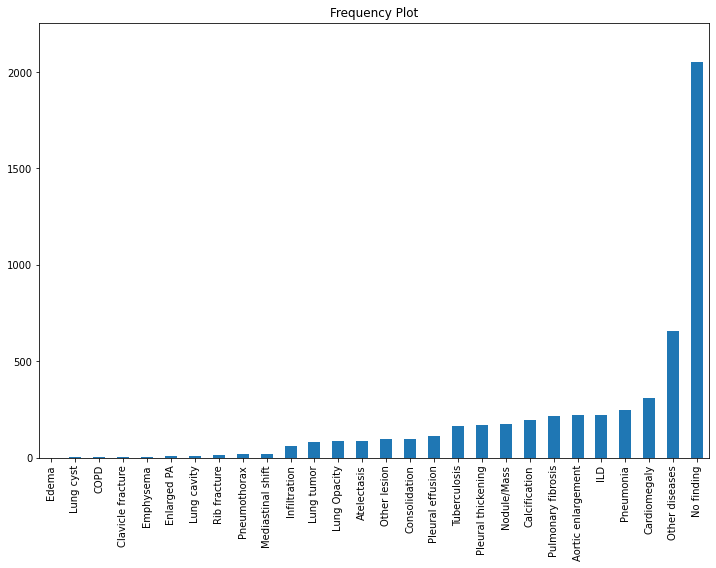

In [19]:
df_test

,0
Edema,0
Lung cyst,2
COPD,2
Clavicle fracture,2
Emphysema,3
Enlarged PA,8
Lung cavity,9
Rib fracture,11
Pneumothorax,18
Mediastinal shift,20


### Pneumonia, tuberculosis, lung tumor, pleural effusion, other diseases, and no finding

In [189]:
df

,0
Edema,13
Clavicle fracture,27
Lung cyst,33
COPD,36
Lung cavity,51
Emphysema,81
Rib fracture,90
Pneumothorax,96
Enlarged PA,131
Mediastinal shift,150


In [1]:
10606+4377+1038+291+750+919

17981

### Local annotations

In [190]:
train_local_annotations.head(10)

,image_id,rad_id,class_name,x_min,y_min,x_max,y_max
0,000434271f63a053c4128a0ba6352c7f,R2,No finding,NaN,NaN,NaN,NaN
1,000434271f63a053c4128a0ba6352c7f,R3,No finding,NaN,NaN,NaN,NaN
2,000434271f63a053c4128a0ba6352c7f,R6,No finding,NaN,NaN,NaN,NaN
3,00053190460d56c53cc3e57321387478,R11,No finding,NaN,NaN,NaN,NaN
4,00053190460d56c53cc3e57321387478,R2,No finding,NaN,NaN,NaN,NaN
5,00053190460d56c53cc3e57321387478,R7,No finding,NaN,NaN,NaN,NaN
6,0005e8e3701dfb1dd93d53e2ff537b6e,R10,Infiltration,900.956970,587.809021,1205.359985,888.710999
7,0005e8e3701dfb1dd93d53e2ff537b6e,R10,Lung Opacity,900.956970,587.809021,1205.359985,888.710999
8,0005e8e3701dfb1dd93d53e2ff537b6e,R8,Consolidation,932.471985,567.778992,1197.770020,896.408997
9,0005e8e3701dfb1dd93d53e2ff537b6e,R8,Nodule/Mass,932.471985,567.778992,1197.770020,896.408997


In [191]:
print(np.unique(train_local_annotations['rad_id']))

['R1' 'R10' 'R11' 'R12' 'R13' 'R14' 'R15' 'R16' 'R17' 'R2' 'R3' 'R4' 'R5'
 'R6' 'R7' 'R8' 'R9']


In [218]:
print(np.unique(train_local_annotations['class_name']))
print(len(np.unique(train_local_annotations['class_name'])))

['Aortic enlargement' 'Atelectasis' 'Calcification' 'Cardiomegaly'
 'Clavicle fracture' 'Consolidation' 'Edema' 'Emphysema' 'Enlarged PA'
 'ILD' 'Infiltration' 'Lung Opacity' 'Lung cavity' 'Lung cyst'
 'Mediastinal shift' 'No finding' 'Nodule/Mass' 'Other lesion'
 'Pleural effusion' 'Pleural thickening' 'Pneumothorax'
 'Pulmonary fibrosis' 'Rib fracture']
23
